# Spatial frequency task with Muse

This experiment uses visual stimuli with different spatial frequencies to produce strong ERPs, beta (and potentially, gamma) oscillations, and induce alpha reset. It is meant to be used as a benchmark paradigm for testing signal quality, since it induces various EEG responses.

Stimuli were presented for 1.5 s with a random intertrial interval of 1.0 to 1.5 s. The task was to passively fixate the center of the screen while the stimuli were displayed. Three blocks of 400 s were recorded for a single partipant.

The low spatial frequency stimulus was a grating with `freq=0.1`, while the high spatial frequency stimulus was a grating with `freq=4.1`.

This protocol was inspired by:

> Hermes, Dora, K. J. Miller, B. A. Wandell, and Jonathan Winawer. "Stimulus dependence of gamma oscillations in human visual cortex." Cerebral Cortex 25, no. 9 (2015): 2951-2959.

Moreover, an external electrode was added to the Muse headband to collect data at POz.

In [1]:
import os
import sys
from collections import OrderedDict

import pandas as pd
import numpy as np
import seaborn as sns
from mne import Epochs, find_events
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append('../muse')
import utils

## Load data into MNE objects

In [2]:
subject = 1
session = 1
raw = utils.load_data('visual/spatial_freq', sfreq=256., 
                      subject_nb=subject, session_nb=session,
                      ch_ind=[0, 1, 2, 3, 4], 
                      replace_ch_names={'Right AUX': 'POz'})

Creating RawArray with float64 data, n_channels=6, n_times=57612
    Range : 0 ... 57611 =      0.000 ...   225.043 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=57624
    Range : 0 ... 57623 =      0.000 ...   225.090 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=57612
    Range : 0 ... 57611 =      0.000 ...   225.043 secs
Ready.


## Power Spectrum

Effective window size : 8.000 (s)


/home/hubert/.pyenv/versions/3.6.0/envs/musetools/lib/python3.6/site-packages/mne/viz/raw.py:614: DeprecationWarning: In version 0.15 average will default to False and spatial_colors will default to True.
  'spatial_colors will default to True.', DeprecationWarning)


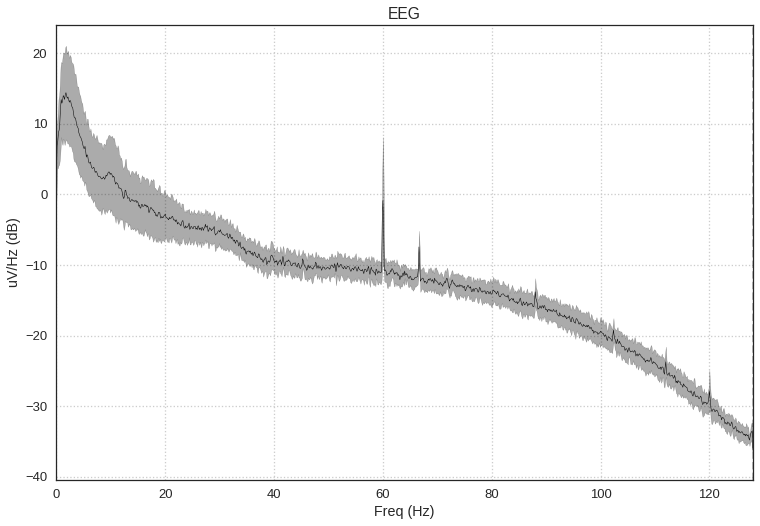

In [3]:
raw.plot_psd(tmax=np.inf);

## ERP analysis

We expect a noticeable ERP response both at the onset and offset of the grating presentation.

In [4]:
# Bandpass filter
filt_raw = raw.copy().filter(1, 30, method='iir')

# Extract epochs
events = find_events(filt_raw)
event_id = {'Low (start)': 1, 'High (start)': 2,
            'Low (end)': 3, 'High (end)': 4}

epochs = Epochs(filt_raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 100e-6}, preload=True, 
                verbose=False, picks=[0, 2, 3, 4, 1])

Setting up band-pass filter from 1 - 30 Hz
480 events found
Events id: [1 2 3 4]


### Onset

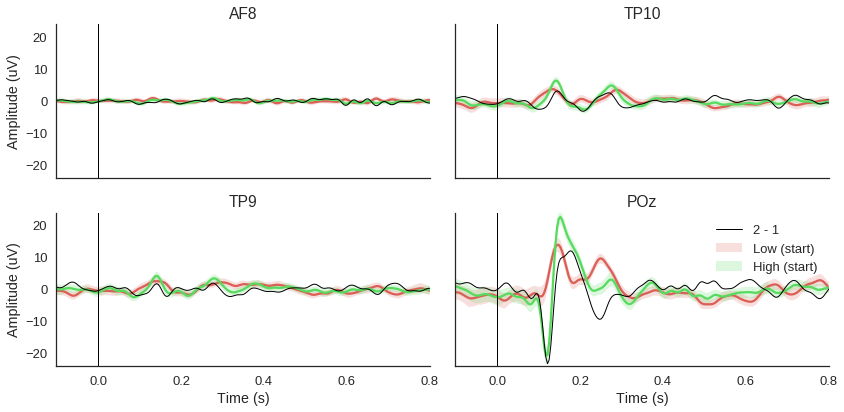

In [5]:
# Time domain visualization
conditions = OrderedDict()
conditions['Low (start)'] = [1]
conditions['High (start)'] = [2]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=(1, 2), ylim=(-24, 24))

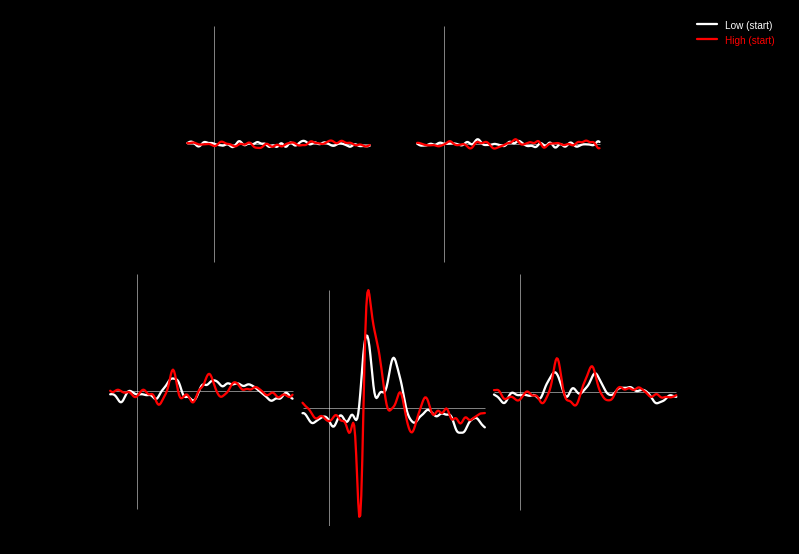

In [6]:
from mne.viz import plot_evoked_topo

h = epochs['High (start)'].copy().crop(-0.1, 0.6).average()
l = epochs['Low (start)'].copy().crop(-0.1, 0.6).average()

plot_evoked_topo([l, h], show=False, color=['w', 'r']);

There is a clear difference between the low and high spatial frequency conditions, especially at POz where the high spatial frequency condition induces a very sharp negative deflection at around 100 ms.

### Offset

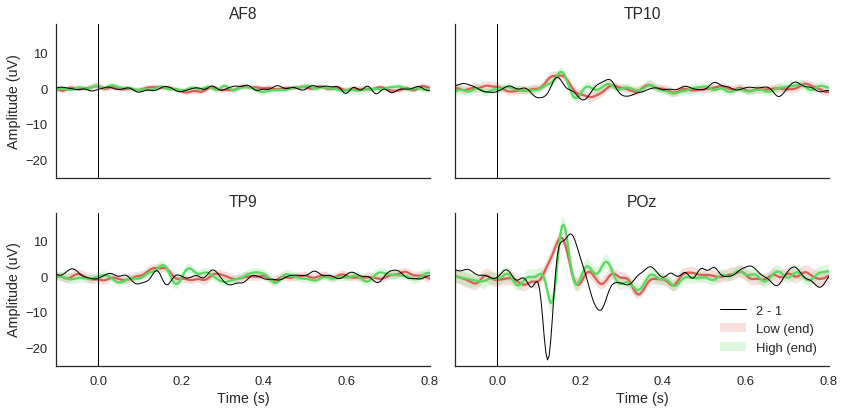

In [7]:
# Time domain visualization
conditions = OrderedDict()
conditions['Low (end)'] = [3]
conditions['High (end)'] = [4]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=(1, 2), ylim=(-25, 18))

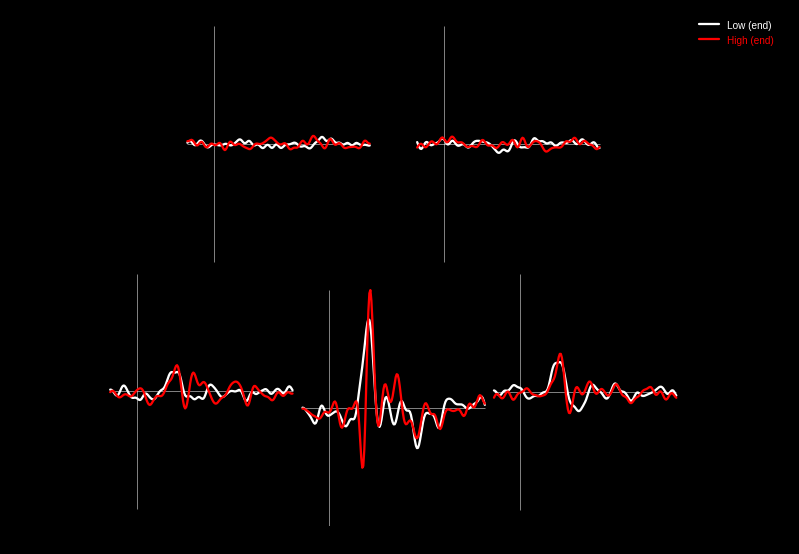

In [8]:
h = epochs['High (end)'].copy().crop(-0.1, 0.6).average()
l = epochs['Low (end)'].copy().crop(-0.1, 0.6).average()

plot_evoked_topo([l, h], show=False, color=['w', 'r']);

There is again a clear difference between the two conditions, although the ERP response is weaker than during the onset.

## Oscillatory activity analysis

Oscillatory activity in the beta and gamma bands is expected during the presentation of the gratings, and an alpha reset phenomenon is expected once the gratings have disappeared.

In [9]:
# Extract epochs covering a entire trial (~3 s)
events = find_events(raw)
event_id = {'Low': 1, 'High': 2}

epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=3, baseline=None,
                reject={'eeg': 100e-6}, preload=True, 
                verbose=False, picks=[0, 1, 2, 3, 4])

480 events found
Events id: [1 2 3 4]


### Power spectral density

Effective window size : 4.016 (s)
Effective window size : 4.016 (s)


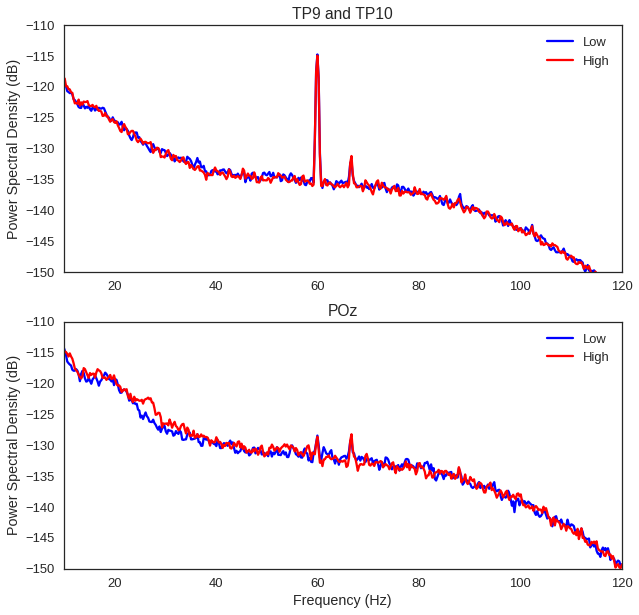

In [10]:
from mne.time_frequency import psd_welch

f, axs = plt.subplots(2, 1, figsize=(10, 10))
psd1, freq1 = psd_welch(epochs['Low'], n_fft=1028, n_per_seg=256 * 3)
psd2, freq2 = psd_welch(epochs['High'], n_fft=1028, n_per_seg=256 * 3)
psd1 = 10 * np.log10(psd1)
psd2 = 10 * np.log10(psd2)

psd1_mean = psd1.mean(0)
psd1_std = psd1.mean(0)

psd2_mean = psd2.mean(0)
psd2_std = psd2.mean(0)

axs[0].plot(freq1, psd1_mean[[0, 3], :].mean(0), color='b', label='Low')
axs[0].plot(freq2, psd2_mean[[0, 3], :].mean(0), color='r', label='High')

axs[1].plot(freq1, psd1_mean[4, :], color='b', label='Low')
axs[1].plot(freq2, psd2_mean[4, :], color='r', label='High')

axs[0].set_title('TP9 and TP10')
axs[1].set_title('POz')
axs[0].set_ylabel('Power Spectral Density (dB)')
axs[1].set_ylabel('Power Spectral Density (dB)')
axs[0].set_xlim((10, 120))
axs[1].set_xlim((10, 120))
axs[0].set_ylim((-150, -110))
axs[1].set_ylim((-150, -110))
axs[1].set_xlabel('Frequency (Hz)')
axs[0].legend()
axs[1].legend()

plt.show()

While the spectrum at temporal electrodes does not show much, the spectrum at POz shows a clear difference in beta power (around 25 Hz) between the low and high spatial frequency conditions. However, a difference in gamma is not directly visible for this particular participant. (Please note that the two peaks at 60 and 67 Hz are environmental electrical noise.)

Let's visualize this phenomenon with a Time-Frequency plot.

Applying baseline correction (mode: logratio)


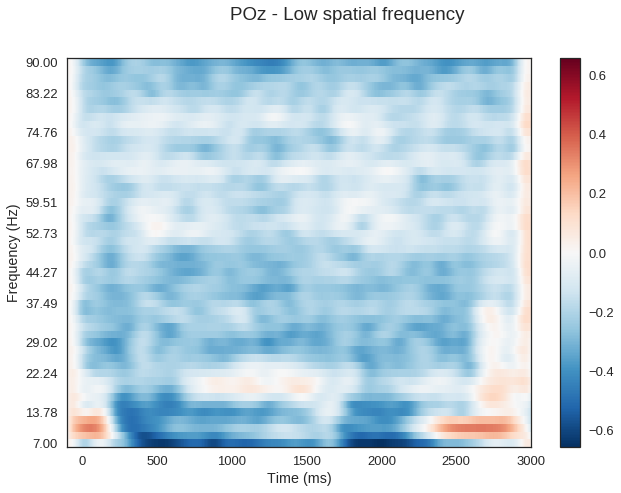

Applying baseline correction (mode: logratio)


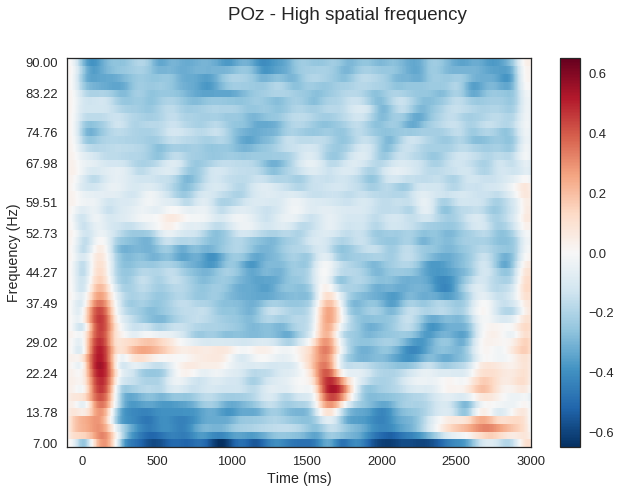

In [11]:
from mne.time_frequency import tfr_morlet

freqs = np.linspace(7, 90, num=50)
tfr, itc = tfr_morlet(epochs['Low'], freqs=freqs, 
                      n_cycles=freqs/2, return_itc=True)
tfr.plot(picks=[4], baseline=(-0.5, -0.1), mode='logratio', 
         title='POz - Low spatial frequency');

tfr, itc = tfr_morlet(epochs['High'], freqs=freqs, 
                      n_cycles=freqs/2, return_itc=True)
tfr.plot(picks=[4], baseline=(-0.5, -0.1), mode='logratio', 
         title='POz - High spatial frequency');

The time course of the trial is clearly seen from the Time-Frequency plot: 

1. The initial onset ERP produces a wide-band event right after `t=0`, visible in both conditions but especially in the high frequency condition;
2. The 1.5-s presentation of the spatial grating induces high beta activity (starting around 29 Hz and decreasing to around 25 Hz) in the high frequency condition, and central beta activity (around 22 Hz) in the low frequency condition;
3. The offset ERP again produces wide-band activity right after `t=1500 ms`, however of smaller amplitude than during the onset;
4. Finally, alpha power resumes about 1 s after the offset in both conditions.

### Importance of different frequencies

We want to identify which EEG frequency bands significantly differ from one spatial frequency to another. To do so, we can train separate classifiers, each one using a different frequency as input. We can then look for bands that led to significantly different than zero performance. The activity in these bands is likely to be induced by high or low spatial frequency gratings.

**NOTE**: The following code will take some time to run (probably at least 10 minutes depending on your hardware).

In [12]:
from pyriemann.stats import PermutationDistance, PermutationModel
from pyriemann.estimation import CospCovariances
from pyriemann.spatialfilters import CSP
from pyriemann.classification import TSclassifier, TangentSpace
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from scipy.stats import ttest_1samp


# pipe = make_pipeline(CSP(2), StandardScaler(), LogisticRegression())
pipe = make_pipeline(TangentSpace('logeuclid'), LogisticRegression())

# Extract epochs
events = find_events(raw)
event_id = {'Low': 1, 'High': 2}

epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=0.5, tmax=1.5, baseline=None,
                reject={'eeg': 100e-6}, preload=True, 
                verbose=False, picks=[0, 1, 2, 3, 4])

X = epochs.copy().pick_types(eeg=True, stim=False).get_data()
y = epochs.events[:, 2]

# Compute cospectral covariance matrices (see https://arxiv.org/pdf/0812.0494.pdf, p.17)
fmin = 1.0
fmax = 80
win = 128
cosp = CospCovariances(window=win, overlap=0.99, fmin=fmin, fmax=fmax,
                       fs=epochs.info['sfreq'])
covmats = cosp.fit_transform(1e6 * X)

fr = np.fft.fftfreq(win)[0:int(win/2)] * epochs.info['sfreq']
fr = fr[(fr >= fmin) & (fr <= fmax)]

pv = []
Fv = []
# For each frequency bin, estimate the stats
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)

for i in range(covmats.shape[3]):
    ptest = PermutationModel(50, model=pipe, cv=cv, n_jobs=-1, 
                             scoring='roc_auc')
        
    p, F = ptest.test(covmats[::1, :, :, i], y[::1]==np.max(y))    
    F = F[0]  # the first value was obtained on the non-permuted data
    print(F, p)
    pv.append(p)
    Fv.append(F)

480 events found
Events id: [1 2 3 4]
Performing permutations : [98.0%]
0.493793103448 0.52
Performing permutations : [98.0%]
0.491954022989 0.56
Performing permutations : [98.0%]
0.521149425287 0.48
Performing permutations : [98.0%]
0.564367816092 0.16
Performing permutations : [98.0%]
0.554022988506 0.12
Performing permutations : [98.0%]
0.570574712644 0.14
Performing permutations : [98.0%]
0.500459770115 0.42
Performing permutations : [98.0%]
0.548505747126 0.14
Performing permutations : [98.0%]
0.525747126437 0.36
Performing permutations : [98.0%]
0.534482758621 0.24
Performing permutations : [98.0%]
0.568735632184 0.1
Performing permutations : [98.0%]
0.566666666667 0.12
Performing permutations : [98.0%]
0.66367816092 0.02
Performing permutations : [98.0%]
0.698620689655 0.02
Performing permutations : [98.0%]
0.540459770115 0.22
Performing permutations : [98.0%]
0.501609195402 0.46
Performing permutations : [98.0%]
0.440689655172 0.78
Performing permutations : [98.0%]
0.4363218390

(<matplotlib.figure.Figure at 0x7fad3843ac88>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fad384574a8>)

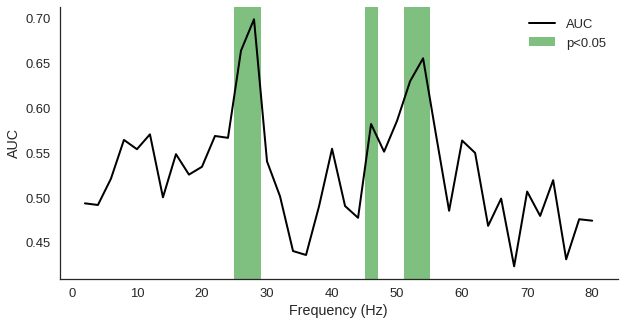

In [13]:
# Plot AUC across frequencies and significant regions
utils.plot_highlight_regions(fr, Fv, pv, hue_thresh=0.05, xlabel='Frequency (Hz)', 
                             ylabel='AUC', legend_str=('AUC', 'p<0.05'))

We see that there are two frequency regions where there was a significant difference between the two task conditions: high beta and low gamma. This indicates that the two tasks indeed evoked different patterns of oscillatory activity.